In [1]:
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l
from IPython import display


In [2]:
trans = transforms.ToTensor()

mnist_train = torchvision.datasets.FashionMNIST(
    root='./data', train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(
    root="./data", train=False, transform=trans, download=True)

print(len(mnist_train), len(mnist_test))
print(mnist_train[0][0].shape)

60000 10000
torch.Size([1, 28, 28])


array([<AxesSubplot:title={'center':'ankle boot'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'dress'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'pullover'}>,
       <AxesSubplot:title={'center':'sneaker'}>,
       <AxesSubplot:title={'center':'pullover'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'ankle boot'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'sneaker'}>,
       <AxesSubplot:title={'center':'ankle boot'}>,
       <AxesSubplot:title={'center':'trouser'}>,
       <AxesSubplot:title={'center':'t-shirt'}>], dtype=object)

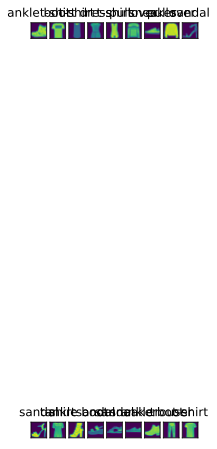

In [3]:
def get_fashion_mnist_label(labels):
    """returns textlabel of Fashion-MNIST datasets"""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress',
                   'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]


def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """draw images list"""
    figsize = (num_rows * scale, num_cols * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            ax.imshow(img.numpy())
        else:
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes


d2l.use_svg_display()
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_label(y))


In [4]:
batch_size = 256


def get_dataloader_workers():
    return 4


train_iter = data.DataLoader(
    mnist_train, batch_size, shuffle=True, num_workers=get_dataloader_workers())

timer = d2l.Timer()
for X, y in train_iter:
    continue
f'{timer.stop():.2f} sec'


'1.23 sec'

In [5]:
def load_data_fashion_mnist(batch_size, resize=None):
    """download Fashion-MNIST datasets, then load in memory"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root='./data', train=True, transform=trans, download=True
    )
    mnist_test = torchvision.datasets.FashionMNIST(
        root='./data', train=False, transform=trans, download=True
    )
    return (data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers())
            )


In [6]:
train_iter, test_iter = load_data_fashion_mnist(batch_size)

num_inputs = 784
num_outputs = 10

W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

### 实现softmax步骤

1. 使用`exp`对每个项求幂
2. 对每一行求和（小批量中每个样本是一行），得到每个样本的规范化常数
3. 将每一行除以其规范化常数，确保结果的和为1

$$
softmax(\boldsymbol{X}_{ij})=\frac{exp(\boldsymbol{X}_{ij})}{\sum_{k}exp(\boldsymbol{X}_{ik})}
$$

In [7]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition # 广播机制

In [8]:
def net(X):
    return softmax(torch.matmul(X.reshape(-1, W.shape[0]), W) + b)


In [9]:
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[range(len(y_hat)), y])


In [10]:
def accuracy(y_hat, y):
    """calculate the number of correct predict"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())


In [11]:
class Accumulator:
    """accmulating on n vars"""

    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


In [12]:
def evaluate_accuracy(net, data_iter):
    """evaluate the accuracy of datasets on that very model"""
    if isinstance(net, torch.nn.Module):
        net.eval()
    metric = Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]


In [13]:
evaluate_accuracy(net, test_iter)


0.0599

In [14]:
def train_epoch(net, train_iter, loss, updater):
    """train model with a epoch"""
    if isinstance(net, torch.nn.Module):
        net.train()
    metric = Accumulator(3)
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.mean().backward()
            updater.stop()
        else:
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    return metric[0] / metric[2], metric[1] / metric[2]


In [15]:
class Animator:
    """draw data with animation"""

    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear', fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1, figsize=(3.5, 2.5)):
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)


In [16]:
def train(net, train_iter, test_iter, loss, num_epochs, updater):
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[
                        0.3, 0.9], legend=['trains loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch+1, train_metrics+(test_acc, ))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc


In [17]:
lr = 0.1

def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

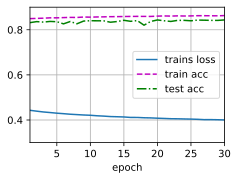

In [19]:
num_epochs = 30
train(net, train_iter, test_iter, cross_entropy, num_epochs, updater)


In [ ]:
def predict(net, test_iter, n=6):
    for X, y in test_iter:
        break
    trues = get_fashion_mnist_label(y)
    preds = get_fashion_mnist_label(net(X).argmax(axis=1))
    titles = [true+'\n'+pred for true, pred in zip(trues, preds)]
    show_images(X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])


predict(net, test_iter)
